2025-01-17 13:07:48.172965: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 13:07:48.183543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737115668.197061  106481 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737115668.201246  106481 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 13:07:48.214642: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 576)            │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,300,724 (4.96 MB)

 Trainable params: 361,604 (1.38 MB)

 Non-trainable params: 939,120 (3.58 MB)

connection established, loading frame paths
rel paths of framelabels loaded
connection established, loading frame paths
rel paths of framelabels loaded
DataGeneratorSkillBorders init done
connection established, loading frame paths
rel paths of framelabels loaded
DataGeneratorSkillBorders init done
Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - iou: 0.2100 - loss: 0.0220
Epoch 1: val_loss improved from inf to 0.00644, saving model to weights/last_trained_model_best.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - iou: 0.2100 - loss: 0.0220 - val_iou: 0.3023 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - iou: 0.2861 - loss: 0.0087
Epoch 2: val_loss did not improve from 0.00644
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - iou: 0.2861 - loss: 0.0087 - val_iou: 0.2393 - val_loss: 0.0080 - learning_rate: 0.0010
connection established, loading frame paths
rel paths of framelabels loaded
connection established, loading frame paths
rel paths of framelabels 

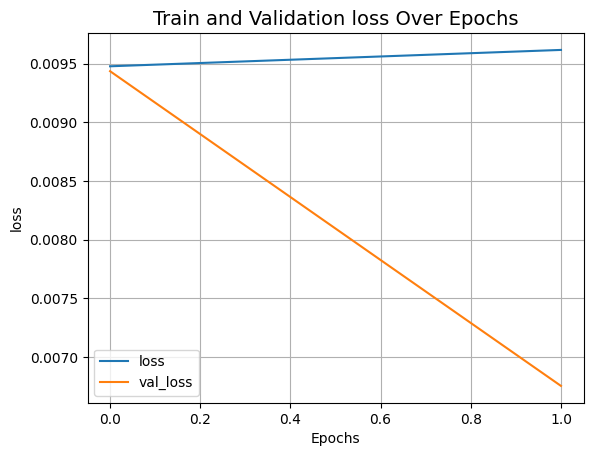

,iou,loss,val_iou,val_loss,learning_rate,epoch
0,0.170429,0.009478,0.276100,0.009436,0.001,1
1,0.224544,0.009617,0.321303,0.006753,0.001,2


In [1]:
import keras
import numpy as np
import sys
import tensorflow as tf
import pandas as pd

sys.path.append('.')

from helpers import iou
from FrameLoader import FrameLoader
from DataGeneratorFrames import DataGeneratorFrames
from DataRepository import DataRepository

from models.GoogleNet import get_model as get_model_googlenet
from models.MobileNetV3Small import get_model as get_model_mobilenet
from models.RandomCNN import get_model as get_model_randomcnn
from models.vitransformer_enc import get_model as get_model_vit

def train_model(model, info_train):
    """Returns history object"""
    DIM = selected_info['dim']

    repo = DataRepository()
    train_generator = DataGeneratorFrames(
        frameloader=FrameLoader(repo),
        train_test_val="train",
        dim=(DIM,DIM),
        batch_size=info_train['batch_size'],
    )
    val_generator = DataGeneratorFrames(
        frameloader=FrameLoader(repo),
        train_test_val="test",
        dim=(DIM,DIM),
        batch_size=info_train['batch_size'],
    )
    
    callbacks = [
        keras.callbacks.ModelCheckpoint('weights/last_trained_model_best.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    ]
    if info_train["early_stopping"]:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1))
    
    optimizer = keras.optimizers.Adam(learning_rate=info_train['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=[iou])

    history = model.fit(
        train_generator,
        epochs=info_train['epochs'],
        callbacks=callbacks,
        verbose=1,
        validation_data=val_generator
    )

    return history

###############################################################################

info_googlenet = {
    'name' : 'googlenet',
    'dim' : 512,
    'batch_size' : 8,
    'learning_rate' : 1e-4,
    'use_batch_norm' : True,
    'get_model_function' : get_model_googlenet,
}
info_vit = {
    'name' : 'vision_transformer',
    'dim' : 224,
    'patch_size' : 16, # (224 / 16) **2 = 196 patches
    'dim_embedding' : 64,
    'num_heads': 4,
    'encoder_blocks': 4,
    'mlp_head_units' : [1024, 256, 64],  # Size of the dense layers
    'batch_size' : 8,
    'min_epochs' : 15,
    'learning_rate' : 1e-3,
    'weight_decay' : 1e-4,
    'get_model_function' : get_model_vit,
}
info_mobilenet = {
    'name' : 'mobilenet',
    'dim' : 224, # pre-trained default
    'batch_size' : 32,
    'min_epochs' : 15,
    'has_frozen_layers' : True,
    'learning_rate' : 1e-3,
    'get_model_function' : get_model_mobilenet,
}

###############################################################################
selected_info = info_mobilenet
# TODO : continue training
# TODO : save model
# TODO : write results
###############################################################################

trainings_info = {
    'epochs' : 2,
    'early_stopping' : False,
    'early_stopping_patience' : 3,
    'batch_size' : selected_info['batch_size'],
    'learning_rate' : 1e-4 if 'learning_rate' not in selected_info.keys() else selected_info['learning_rate'],
}
trainings_info['weight_decay'] = trainings_info['learning_rate'] / 10 if 'weight_decay' not in selected_info.keys() else selected_info['weight_decay']

model = selected_info['get_model_function'](selected_info)
model.summary()

history = train_model(model, info_train=trainings_info)
if 'has_frozen_layers' in selected_info.keys():
    trainings_info['epochs'] = 2
    model.trainable = True
    history = train_model(model, info_train=trainings_info)

print(history)

import matplotlib.pyplot as plt
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")

df_history = pd.DataFrame(history.history)
df_history["epoch"] = df_history.index + 1
df_history

In [2]:
history.history

{'iou': [0.1704290509223938, 0.2245437055826187],
 'loss': [0.00947795994579792, 0.009617486037313938],
 'val_iou': [0.27610015869140625, 0.3213031589984894],
 'val_loss': [0.009436126798391342, 0.006752798333764076],
 'learning_rate': [0.0010000000474974513, 0.0010000000474974513]}

In [3]:
history.params


{'verbose': 1, 'epochs': 2, 'steps': 1}

In [4]:
history